# Question answering on the dataset SQuAD 2.0.

In [1]:
import torch.nn as nn
import os
import requests
import json

!pip install transformers

# Dataset

In [2]:
if not os.path.exists('squad'):
    os.mkdir('squad')

url = 'https://rajpurkar.github.io/SQuAD-explorer/dataset/'
res_train = requests.get(f'{url}train-v2.0.json')
res_valid = requests.get(f'{url}dev-v2.0.json')

with open(f'squad/train-v2.0.json', 'wb') as f:
        for chunk in res_train.iter_content(chunk_size=4):
            f.write(chunk)
with open(f'squad/dev-v2.0.json', 'wb') as f:
        for chunk in res_valid.iter_content(chunk_size=4):
            f.write(chunk)

Data extraction

In [3]:
#function to extract context, questions and answers from squad file
#in case there are question without answers we extract an answer from the plausible_answers
def read_squad(path):

    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    contexts, questions, answers = [], [], []
  
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                # check if we need to be extracting from 'answers' or 'plausible_answers'
                if 'plausible_answers' in qa.keys():
                    access = 'plausible_answers'
                else:
                    access = 'answers'
                for answer in qa[access]:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)
    return contexts, questions, answers

train_contexts, train_questions, train_answers = read_squad('squad/train-v2.0.json')
val_contexts, val_questions, val_answers = read_squad('squad/dev-v2.0.json')

In [4]:
#function to find the end of the answer in the dataset
def add_end_index(answers, contexts):
    for answer, context in zip(answers, contexts):
        valid_text = answer['text'] #text that refers to the answer
        start_index = answer['answer_start']
        end_index = start_index + len(valid_text) #define the end

        if context[start_index:end_index] == valid_text: #in case the answer is not exactly the length of the text
            answer['answer_end'] = end_index
        else:# answer is off by 1-2 tokens
            for n in [1, 2]:
                if context[start_index-n:end_index-n] == valid_text:
                    answer['answer_start'] = start_index - n
                    answer['answer_end'] = end_index - n
            
# and apply the function to our two answer lists
add_end_index(train_answers, train_contexts)
add_end_index(val_answers, val_contexts)

In [5]:
# train_contexts,train_questions, train_answers = train_contexts[:20000],train_questions[:20000],train_answers[:20000]

# Preprocess

Tokenization

In [6]:
# from transformers import DistilBertTokenizerFast,BertForQuestionAnswering
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
from transformers import AutoTokenizer,BertForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# tokenize
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True,max_length=384)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True,max_length=384)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Adding tokens for the strating and ending postition

In [7]:
def add_token_positions(encodings, answers):
    start_positions, end_positions = [], []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        shift = 1
        while end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - shift)
            shift += 1
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

# apply function to our data
add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

Utility functions from Squad validate script to calculate F1 scores

In [8]:
import string
import re
def normalize_answer(s):
  """Lower text and remove punctuation, articles and extra whitespace."""
  def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)
  def white_space_fix(text):
    return ' '.join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)
  def lower(text):
    return text.lower()
  return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
  if not s: return []
  return normalize_answer(s).split()
for answer in train_answers:
  gold_toks = get_tokens(answer['text'])
  # print(gold_toks)

def compute_exact(a_gold, a_pred):
  return int(normalize_answer(a_gold) == normalize_answer(a_pred))

In [9]:
import collections
def compute_f1(a_gold, a_pred):
  gold_toks = get_tokens(a_gold)
  pred_toks = get_tokens(a_pred)
  common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
  num_same = sum(common.values())
  if len(gold_toks) == 0 or len(pred_toks) == 0:
    # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
    return int(gold_toks == pred_toks)
  if num_same == 0:
    return 0
  precision = 1.0 * num_same / len(pred_toks)
  recall = 1.0 * num_same / len(gold_toks)
  f1 = (2 * precision * recall) / (precision + recall)
  return f1


# Dataset class definition

In [10]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

# MODEL
not used 

In [11]:
class QA(nn.Module):

    def __init__(self):

        super(QA, self).__init__()
        
        self.bert = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
        # self.bert = BertModel.from_pretrained('bert-base-uncased') #first layer is pretrained bert model
        # self.dropout = nn.Dropout(0.5)
        # self.linear = nn.Linear(768, 3)
        # self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        # dropout_output = self.dropout(pooled_output)
        # linear_output = self.linear(dropout_output)
        # final_layer = self.relu(linear_output)

        # return final_layer
        # return linear_output
        return pooled_output

# FINE TUNING

In [12]:
import matplotlib.pyplot as plt

from transformers import AdamW

def train(model, train_set, valid_set, l_r, epochs, batch_size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    optimizer = AdamW(model.parameters(), lr=l_r)
#     optimizer = torch.optim.Adam(model.parameters(), lr=l_r) #optimizer
    
    train, val = SquadDataset(train_set), SquadDataset(valid_set)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)
    
    model.to(device)

    f1_scores_epoch, train_losses, val_losses =[],[],[]
    for epoch in range(epochs):
      model.train()
      epoch_loss=0
      epoch_val_loss=0
      count = 0
      for batch in train_dataloader:
        count +=1
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask,
                        start_positions=start_positions,
                        end_positions=end_positions)
        loss = outputs[0]
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      with torch.no_grad():
        acc = []
        preds = []
        count = 0
        f1_scores = []
        for batch in val_dataloader:
          count +=1
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          start_true = batch['start_positions'].to(device)
          end_true = batch['end_positions'].to(device)
    
          # make predictions
          outputs = model(input_ids, attention_mask=attention_mask,start_positions=start_true,
                        end_positions=end_true)
         
         
          #Loss
          loss = outputs[0]
          epoch_val_loss += loss.item()


          #f1 scores
          start_pred = torch.argmax(outputs['start_logits'], dim=1)
          end_pred = torch.argmax(outputs['end_logits'], dim=1) + 1
          for i in range(len(batch)):
            pred_txt = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(batch['input_ids'][i][start_pred[i]:end_pred[i]]))
            true_txt = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(batch['input_ids'][i][start_true[i]:end_true[i]]))
            f1_score = compute_f1(true_txt,pred_txt)
          
            f1_scores.append(f1_score)

      # F1_scores
      f1_final=sum(f1_scores)/ len(f1_scores)
#       print("F1_score: ",f1_final)
      
      print('epoch: ',epoch, ' train_loss: ', epoch_loss/len(train_dataloader), ' val_loss: ', epoch_val_loss/len(val_dataloader)," F1_score: ",f1_final)
      train_losses.append(epoch_loss/len(train_dataloader))
      val_losses.append(epoch_val_loss/len(val_dataloader))

    # plotting Learning curves
    plt.title("loss vs. epochs curve")
    plt.ylim(0,5)
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")



Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

epoch:  0  train_loss:  1.3524048480375037  val_loss:  1.2069447937490518  F1_score:  0.5204268436099437
epoch:  1  train_loss:  0.8306179762517769  val_loss:  1.2341891715996656  F1_score:  0.5219374869080292


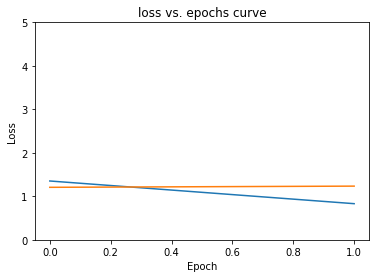

In [13]:
EPOCHS = 2
# model = QA()
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')
# model = BertForQuestionAnswering.from_pretrained('distilbert-base-uncased')
LR=3e-5
BATCH_SIZE = 24
train(model, train_encodings, val_encodings, LR, EPOCHS, BATCH_SIZE)